# LSTM para previsão de casos do COVID-19

Aplicação da rede LSTM desenvolvida e disponibilizada por Luis Ricardo e Marcos Rodrigues.

O código foi organizado e aplicado como requisto para o trabalho de Matemática Computacional (CAP-239-4)

## Definição das funções do modelo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math, pickle, csv, os, warnings

path = os.getcwd() # Diretório atual

Using TensorFlow backend.


In [2]:
def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input, tipo_analise)
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path, list_files_analise[0]), 
                                  header = None, engine = 'python')
    select_analise = serie_analise[serie_analise[0] == pais]
    select_analise = select_analise[[0, 2, 3]]
    return select_analise


def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)

    X = np.float64(X)
    y = np.float64(y)    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

**Função para treinamento automatizado**

In [3]:
def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas, epochs = 50, batch = 1):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X, y, modelo, epochs, batch)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_" + pais + "_" + version, history)
    salvarmodelo("Modelo_" + pais + "_" + version, modelo)

**Função para validação**

In [4]:
def geraValidacao(pais, modelo, n_entrada, n_saida, plt_title = "RMSE: {rmse}"):
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 130, n_saida):
        try:
          input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
          if len(input_array_test) < n_entrada:
            input_array_test = np.append(input_array_test,[0],axis = None)
          y_predict_val_test = predict(modelo,input_array_test,n_entrada)
          list_pred.append(y_predict_val_test)
        except:
          warnings.warn("Problema na lógica de separação para predição", RuntimeWarning)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]

    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.figure(dpi = 150)
    plt.plot(concatenado,'r--', label = 'Valores preditos')
    plt.plot(true,'b',label = 'Valores reais')
    plt.xlabel('Dias')
    plt.ylabel('Casos diários')
    plt.legend(loc ='upper right')
    plt.title(plt_title.format(rmse = str(round(score_rmse, 4))))
    # plt.title('RMSE: %.4f' % (score_rmse))
    
    return score_rmse

In [5]:
os.makedirs('Number_Daily_Cases', exist_ok = True)

# Funções auxiliares

Esta seção apresenta funções auxiliares para múltiplas execuções. Criado para os testes do trabalho da disciplina de Matemática Computacional (CAP-239-4)

In [6]:
def multiplas_execucoes(pais, padroes_de_entrada, plt_title, epochs_range = None, is_walk = False, **kwargs):
  class EpochsChange(RuntimeWarning): ...
  
  def treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs):
    VERSAOT = "v{num}"
    results = {
      'nome_modelo': [],
      'versao': [],
      'entradas': [],
      'rmse': [],
      'epoch': []
    }
    
    for padrao_de_entrada, num in zip(padroes_de_entrada, range(len(padroes_de_entrada))):
      versaot = VERSAOT.format(num = num)
      nmodelo = f"Modelo_{pais}_{versaot}"
      print(nmodelo)

      gerarTreinamento_parametros(pais, versaot, *padrao_de_entrada, **kwargs)
      results['nome_modelo'].append(nmodelo)
      results['versao'].append(versaot)
      results['entradas'].append(padrao_de_entrada)
      
      if kwargs['epochs']:
        results['epoch'].append(kwargs['epochs'])
      else:
        results['epoch'].append(50) # Padrão de épocas

      results['rmse'].append(
          geraValidacao(pais, nmodelo, *padrao_de_entrada, plt_title = plt_title)
      )
    return pd.DataFrame(results)

  if not epochs_range:
    return treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs)
  else:
    warnings.warn("O programa está sendo executado no modo de múltiplas épocas", EpochsChange)
    # Identificando se são passos ou intervalos
    if is_walk:
      _loop = epochs_range
    else:
      _loop = range(*epochs_range)

    res = []
    for i in _loop:
      res.append(treina_modelo(pais, padroes_de_entrada, plt_title, epochs = i))
    return pd.concat(res)
  raise RuntimeError("Os parâmetros inseridos são inválidos")

# Organização dos dados

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('blueteam_national_update_2020_06_03.csv')
df = df[~df.new_confirmed.isna()]

**Organizando os dados**

Abaixo, os dados são organizados para o formato utilizado no código de LSTM desenvolvido e disponibilizado pelo Luis Ricardo e Marcos Rodrigues

> A estrutura dos dados é organizada e salva em um arquivo, da mesma forma como definido no programa original

In [10]:
data = df[df['state'] == 'MG']
data = data[data['place_type'] == 'state']
data = data[data['is_repeated'] == False]
data.set_index('date', inplace = True)
data = data.sort_index()
data['date'] = data.index
data['new_cases'] = data.new_confirmed

Adaptando os dados para o formato das ferramentas

In [11]:
serie_cases = pd.DataFrame({
    0: np.repeat('MG', len(data.index)),
    1: np.arange(0, len(data.index)),
    2: data['date'],
    3: data['new_cases']
})

serie_cases.to_csv("Number_Daily_Cases/daily-cases-covid-19.csv", index = False)

# Execução do modelo

**Predizendo valores para um país**

In [12]:
gerarTreinamento_parametros("MG", "v1", 20, 10, epochs = 5)

Epoch 1/5
58/58 [==============================] - 2s 38ms/step - loss: 0.0239
Epoch 2/5
58/58 [==============================] - 2s 28ms/step - loss: 0.0076
Epoch 3/5
58/58 [==============================] - 2s 28ms/step - loss: 0.0063
Epoch 4/5
58/58 [==============================] - 2s 28ms/step - loss: 0.0062
Epoch 5/5
58/58 [==============================] - 2s 28ms/step - loss: 0.0090


entrou condi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


<Figure size 432x288 with 0 Axes>

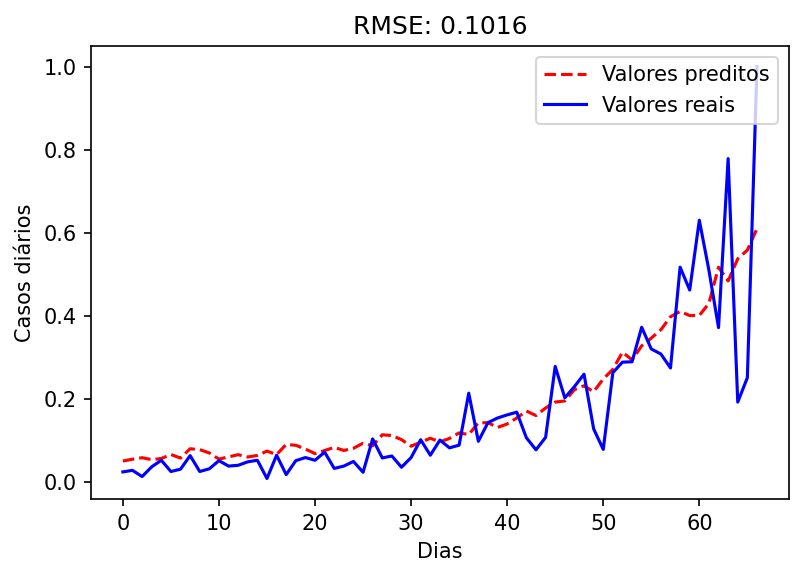

In [13]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 10
score_portugal_1 = geraValidacao("MG", "Modelo_MG_v1", n_entrada, n_saida)

# Múltiplas execuções

Nesta seção, múltiplas execuções são feitas para teste dos parâmetros.

## Epoch único

**Minas Gerais**

Modelo_MG_v0
Epoch 1/2
60/60 [==============================] - 3s 44ms/step - loss: 0.0228
Epoch 2/2
60/60 [==============================] - 2s 35ms/step - loss: 0.0142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v1
Epoch 1/2
51/51 [==============================] - 2s 48ms/step - loss: 0.0290
Epoch 2/2
51/51 [==============================] - 2s 36ms/step - loss: 0.0126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v2
Epoch 1/2
58/58 [==============================] - 2s 40ms/step - loss: 0.0239
Epoch 2/2
58/58 [==============================] - 2s 30ms/step - loss: 0.0131


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v3
Epoch 1/2
70/70 [==============================] - 2s 32ms/step - loss: 0.0199
Epoch 2/2
70/70 [==============================] - 2s 23ms/step - loss: 0.0129


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi


<Figure size 432x288 with 0 Axes>

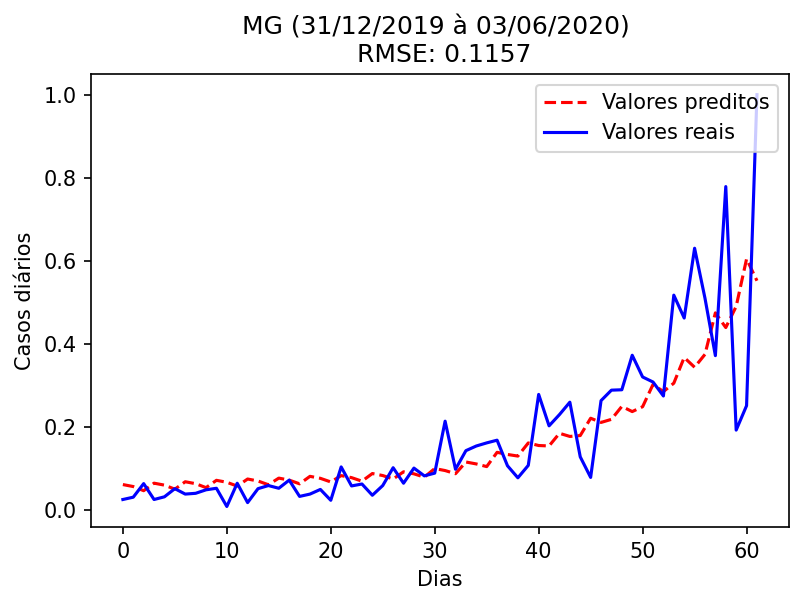

<Figure size 432x288 with 0 Axes>

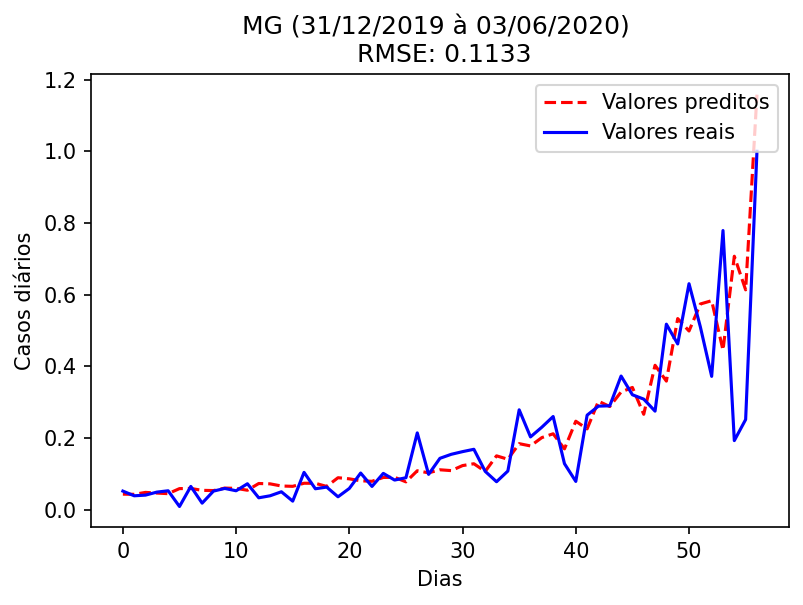

<Figure size 432x288 with 0 Axes>

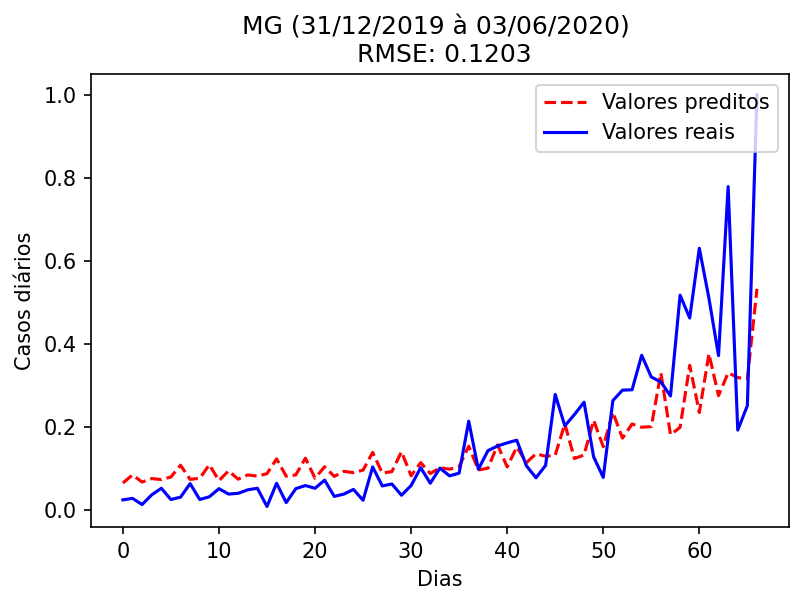

<Figure size 432x288 with 0 Axes>

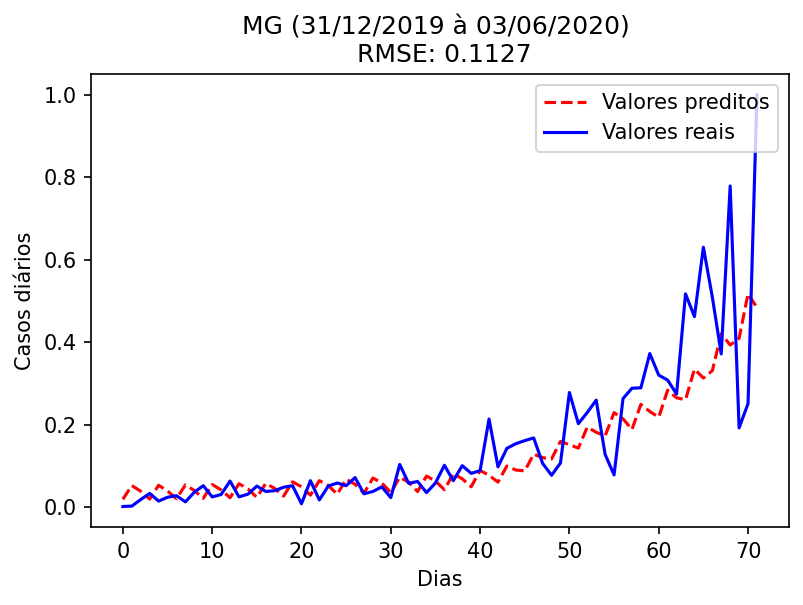

In [14]:
mg_params = multiplas_execucoes("MG", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                "MG (31/12/2019 à 03/06/2020) \n RMSE: {rmse}", epochs = 2)

## Epoch múltiplos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_MG_v0
Epoch 1/5
71/71 [==============================] - 2s 26ms/step - loss: 0.0210
Epoch 2/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0092
Epoch 3/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0083
Epoch 4/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0063
Epoch 5/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0061


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v1
Epoch 1/5
61/61 [==============================] - 2s 40ms/step - loss: 0.0251
Epoch 2/5
61/61 [==============================] - 2s 29ms/step - loss: 0.0125
Epoch 3/5
61/61 [==============================] - 2s 28ms/step - loss: 0.0089
Epoch 4/5
61/61 [==============================] - 2s 28ms/step - loss: 0.0091
Epoch 5/5
61/61 [==============================] - 2s 29ms/step - loss: 0.0062


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v2
Epoch 1/5
51/51 [==============================] - 3s 51ms/step - loss: 0.0271
Epoch 2/5
51/51 [==============================] - 2s 39ms/step - loss: 0.0153
Epoch 3/5
51/51 [==============================] - 2s 40ms/step - loss: 0.0080
Epoch 4/5
51/51 [==============================] - 2s 40ms/step - loss: 0.0078
Epoch 5/5
51/51 [==============================] - 2s 41ms/step - loss: 0.0081


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v0
Epoch 1/10
71/71 [==============================] - 2s 25ms/step - loss: 0.0213
Epoch 2/10
71/71 [==============================] - 1s 16ms/step - loss: 0.0107
Epoch 3/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0065
Epoch 4/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0058
Epoch 5/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 6/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 7/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0060
Epoch 8/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 9/10
71/71 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 10/10
71/71 [==============================] - 1s 18ms/step - loss: 0.0057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v1
Epoch 1/10
61/61 [==============================] - 2s 38ms/step - loss: 0.0289
Epoch 2/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0098
Epoch 3/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0109
Epoch 4/10
61/61 [==============================] - 2s 29ms/step - loss: 0.0077
Epoch 5/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0061
Epoch 6/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0068
Epoch 7/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0061
Epoch 8/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0097
Epoch 9/10
61/61 [==============================] - 2s 28ms/step - loss: 0.0062
Epoch 10/10
61/61 [==============================] - 2s 29ms/step - loss: 0.0061


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v2
Epoch 1/10
51/51 [==============================] - 3s 50ms/step - loss: 0.0271
Epoch 2/10
51/51 [==============================] - 2s 40ms/step - loss: 0.0135
Epoch 3/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0109
Epoch 4/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0094
Epoch 5/10
51/51 [==============================] - 2s 40ms/step - loss: 0.0090
Epoch 6/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0078
Epoch 7/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0080
Epoch 8/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0080
Epoch 9/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0077
Epoch 10/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v0
Epoch 1/20
71/71 [==============================] - 2s 27ms/step - loss: 0.0172
Epoch 2/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0066
Epoch 3/20
71/71 [==============================] - 1s 16ms/step - loss: 0.0064
Epoch 4/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0149
Epoch 5/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0074
Epoch 6/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0058
Epoch 7/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 8/20
71/71 [==============================] - 1s 16ms/step - loss: 0.0076
Epoch 9/20
71/71 [==============================] - 1s 18ms/step - loss: 0.0056
Epoch 10/20
71/71 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 11/20
71/71 [==============================] - 1s 16ms/step - loss: 0.0058
Epoch 12/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 13/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v1
Epoch 1/20
61/61 [==============================] - 2s 37ms/step - loss: 0.0231
Epoch 2/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0102
Epoch 3/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0072
Epoch 4/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0063
Epoch 5/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0071
Epoch 6/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0064
Epoch 7/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0072
Epoch 8/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0064
Epoch 9/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0081
Epoch 10/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0067
Epoch 11/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0067
Epoch 12/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0076
Epoch 13/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v2
Epoch 1/20
51/51 [==============================] - 3s 51ms/step - loss: 0.0303
Epoch 2/20
51/51 [==============================] - 2s 40ms/step - loss: 0.0155
Epoch 3/20
51/51 [==============================] - 2s 40ms/step - loss: 0.0109
Epoch 4/20
51/51 [==============================] - 2s 41ms/step - loss: 0.0088
Epoch 5/20
51/51 [==============================] - 2s 41ms/step - loss: 0.0075
Epoch 6/20
51/51 [==============================] - 2s 41ms/step - loss: 0.0080
Epoch 7/20
51/51 [==============================] - 2s 41ms/step - loss: 0.0075
Epoch 8/20
51/51 [==============================] - 2s 41ms/step - loss: 0.0075
Epoch 9/20
51/51 [==============================] - 2s 40ms/step - loss: 0.0078
Epoch 10/20
51/51 [==============================] - 2s 40ms/step - loss: 0.0073
Epoch 11/20
51/51 [==============================] - 2s 40ms/step - loss: 0.0077
Epoch 12/20
51/51 [==============================] - 2s 39ms/step - loss: 0.0092
Epoch 13/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v0
Epoch 1/50
71/71 [==============================] - 2s 24ms/step - loss: 0.0231
Epoch 2/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0106
Epoch 3/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0066
Epoch 4/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 5/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0057
Epoch 6/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0061
Epoch 7/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0063
Epoch 8/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0056
Epoch 9/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0058
Epoch 10/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 11/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0053
Epoch 12/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0055
Epoch 13/50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_MG_v1
Epoch 1/50
61/61 [==============================] - 2s 38ms/step - loss: 0.0222
Epoch 2/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0099
Epoch 3/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0068
Epoch 4/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0073
Epoch 5/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0085
Epoch 6/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0075
Epoch 7/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0075
Epoch 8/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0089
Epoch 9/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0066
Epoch 10/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0069
Epoch 11/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0069
Epoch 12/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0064
Epoch 13/50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_MG_v2
Epoch 1/50
51/51 [==============================] - 3s 51ms/step - loss: 0.0246
Epoch 2/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0119
Epoch 3/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0155
Epoch 4/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0084
Epoch 5/50
51/51 [==============================] - 2s 46ms/step - loss: 0.0078
Epoch 6/50
51/51 [==============================] - 3s 54ms/step - loss: 0.0088
Epoch 7/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0097
Epoch 8/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0078
Epoch 9/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0082
Epoch 10/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0069
Epoch 11/50
51/51 [==============================] - 2s 39ms/step - loss: 0.0077
Epoch 12/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0077
Epoch 13/50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_MG_v0
Epoch 1/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0211
Epoch 2/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 3/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0072
Epoch 4/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0060
Epoch 5/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0056
Epoch 6/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0075
Epoch 7/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0056
Epoch 8/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0060
Epoch 9/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0069
Epoch 10/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0055
Epoch 11/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 12/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0054

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_MG_v1
Epoch 1/100
61/61 [==============================] - 3s 44ms/step - loss: 0.0239
Epoch 2/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0119
Epoch 3/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0067
Epoch 4/100
61/61 [==============================] - 2s 30ms/step - loss: 0.0061
Epoch 5/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0079
Epoch 6/100
61/61 [==============================] - 2s 30ms/step - loss: 0.0066
Epoch 7/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0088
Epoch 8/100
61/61 [==============================] - 2s 31ms/step - loss: 0.0128
Epoch 9/100
61/61 [==============================] - 2s 30ms/step - loss: 0.0094
Epoch 10/100
61/61 [==============================] - 2s 30ms/step - loss: 0.0065
Epoch 11/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0063
Epoch 12/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0062

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_MG_v2
Epoch 1/100
51/51 [==============================] - 3s 53ms/step - loss: 0.0346
Epoch 2/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0145
Epoch 3/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0113
Epoch 4/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0106
Epoch 5/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0114
Epoch 6/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0081
Epoch 7/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0081
Epoch 8/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0077
Epoch 9/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0076
Epoch 10/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0074
Epoch 11/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0074
Epoch 12/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0073

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi


<Figure size 432x288 with 0 Axes>

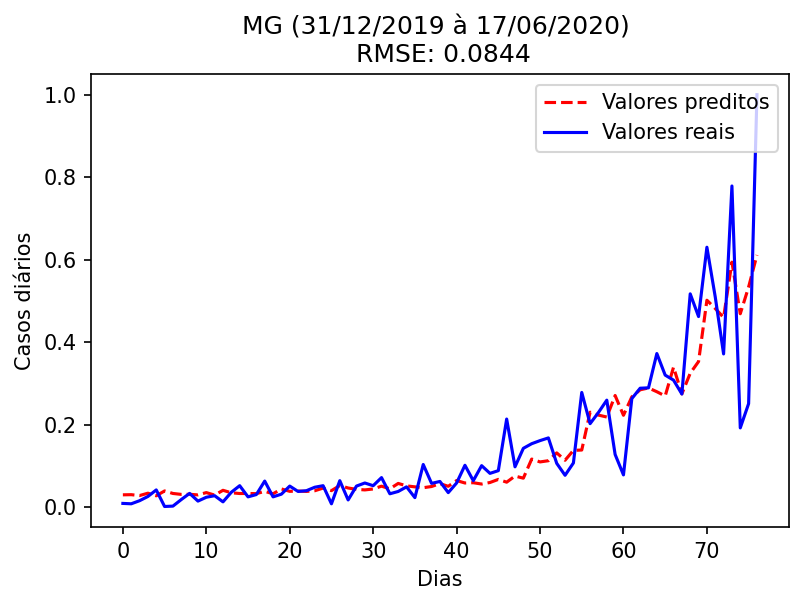

<Figure size 432x288 with 0 Axes>

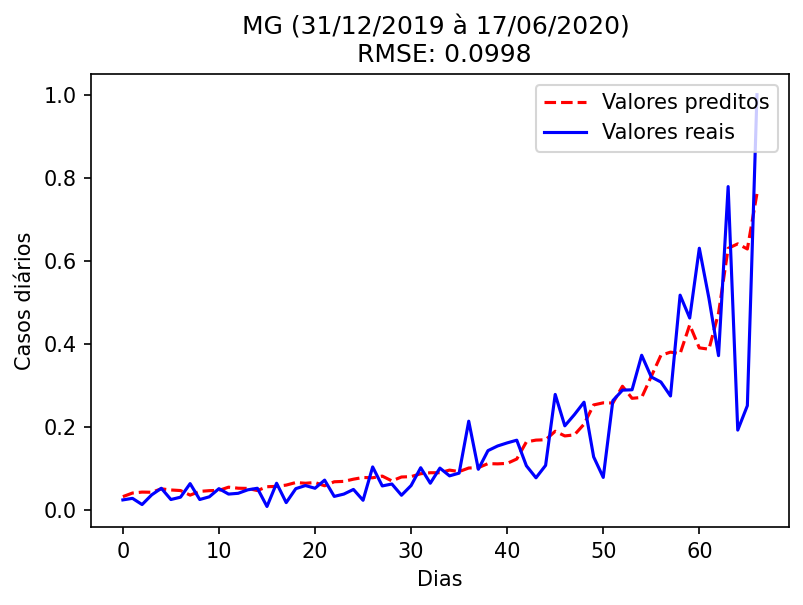

<Figure size 432x288 with 0 Axes>

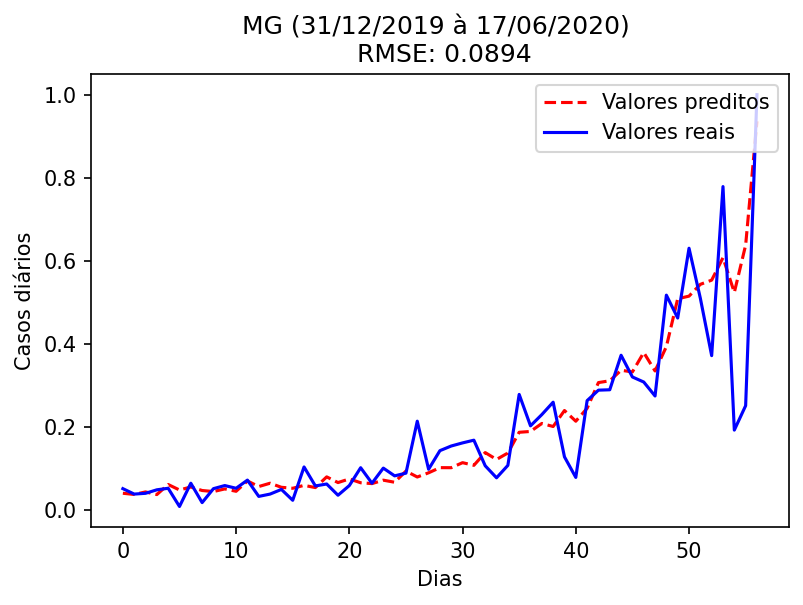

<Figure size 432x288 with 0 Axes>

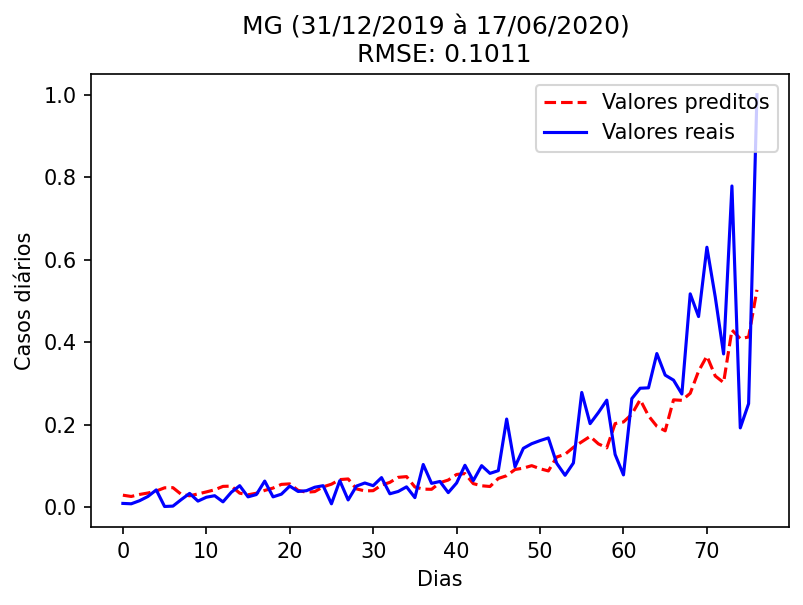

<Figure size 432x288 with 0 Axes>

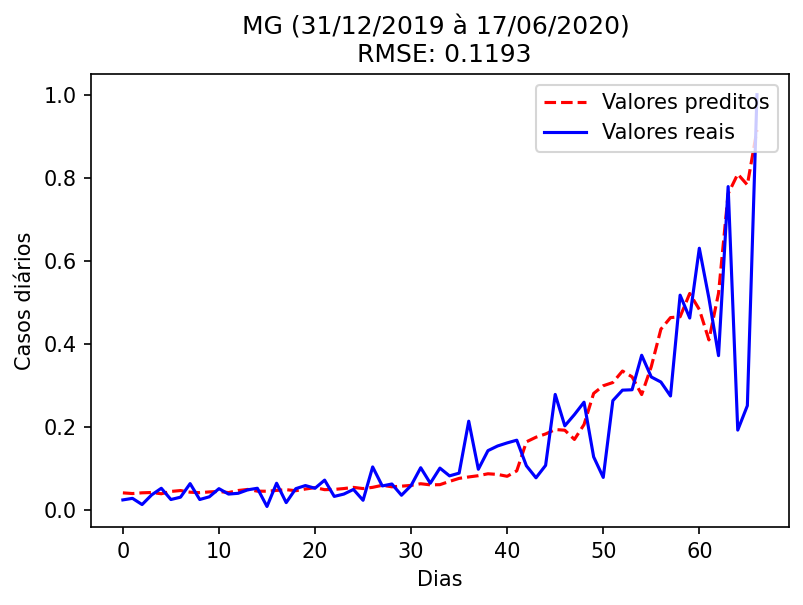

<Figure size 432x288 with 0 Axes>

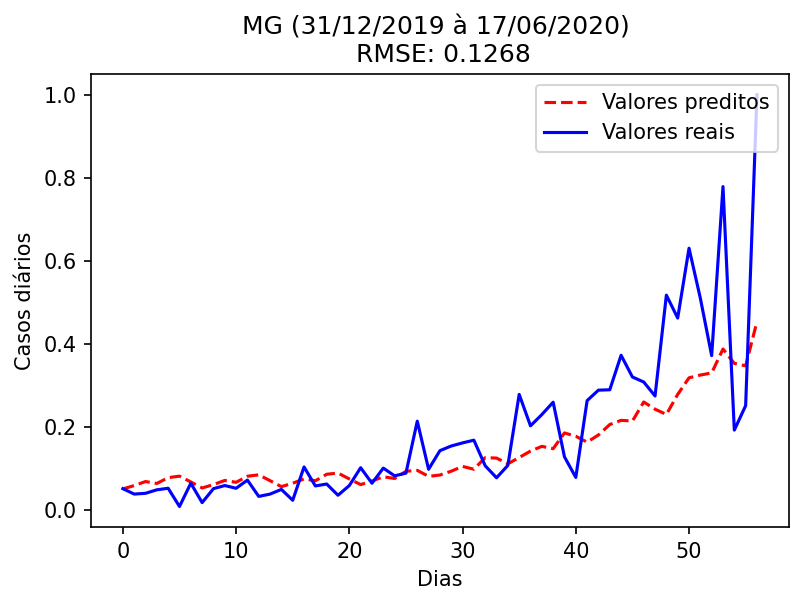

<Figure size 432x288 with 0 Axes>

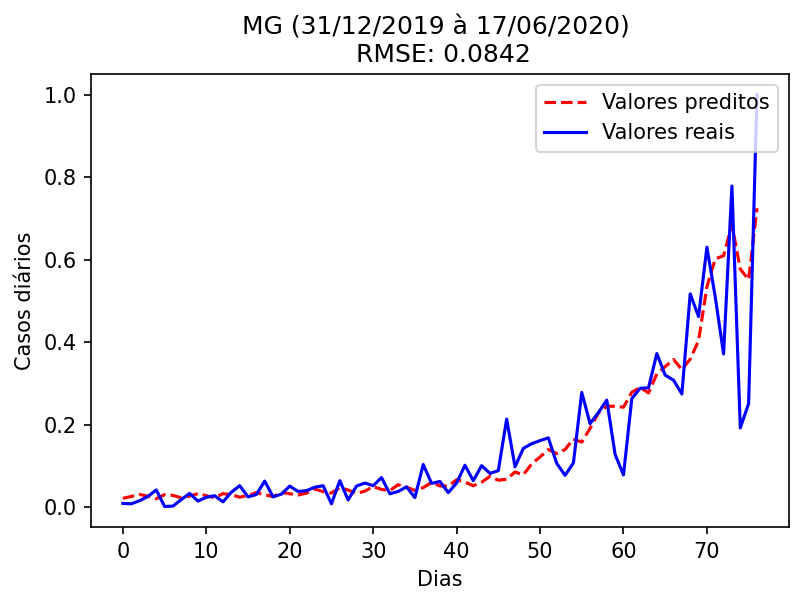

<Figure size 432x288 with 0 Axes>

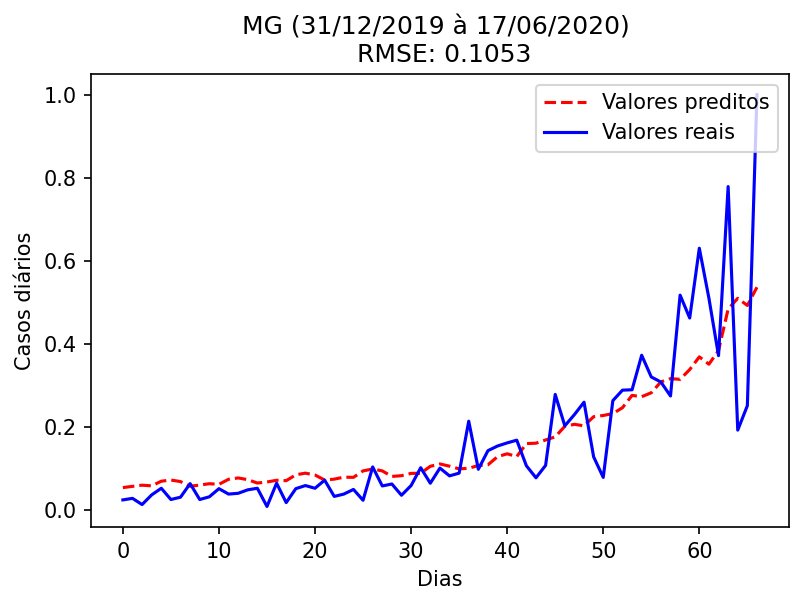

<Figure size 432x288 with 0 Axes>

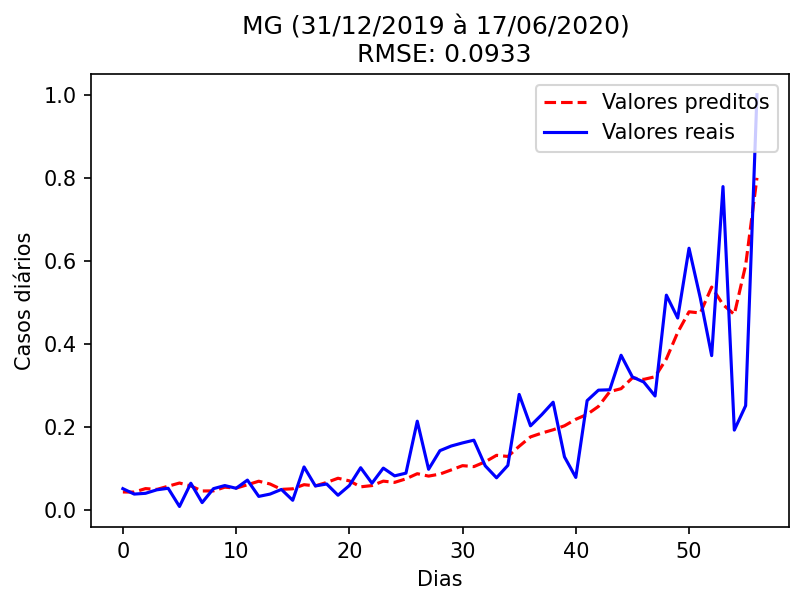

<Figure size 432x288 with 0 Axes>

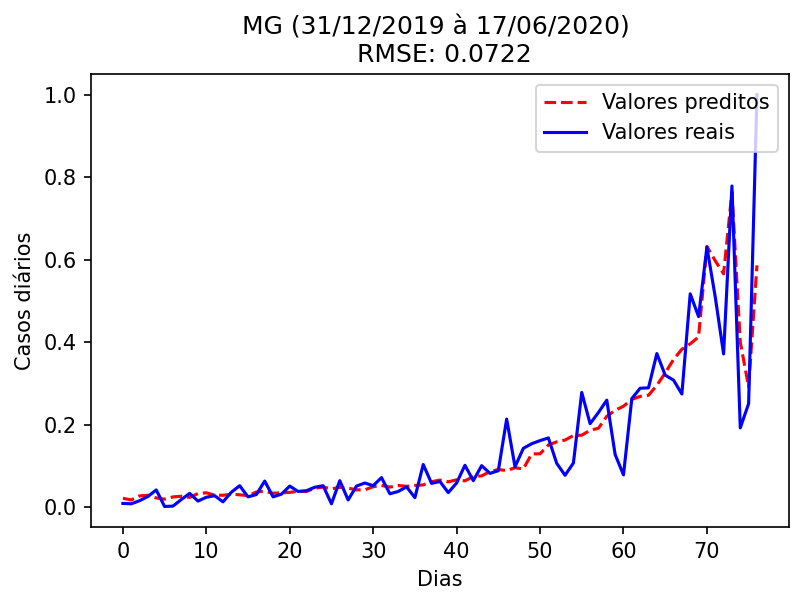

<Figure size 432x288 with 0 Axes>

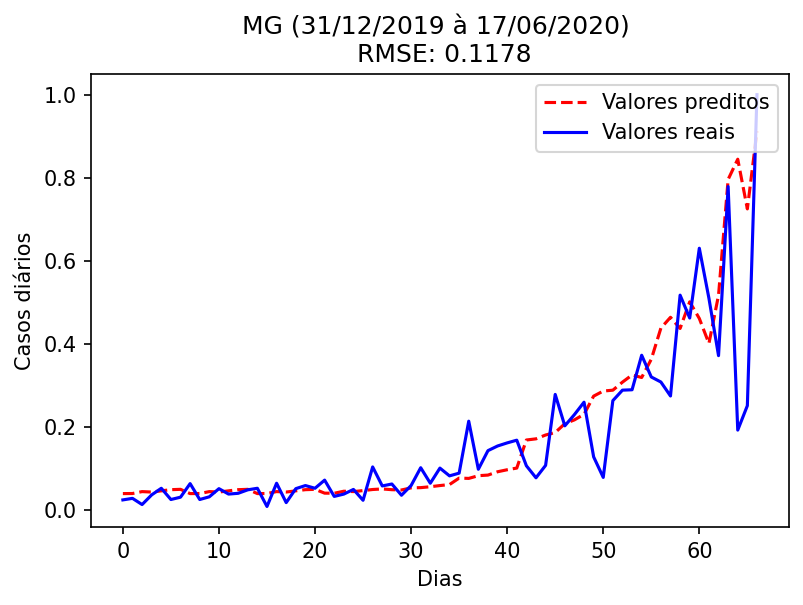

<Figure size 432x288 with 0 Axes>

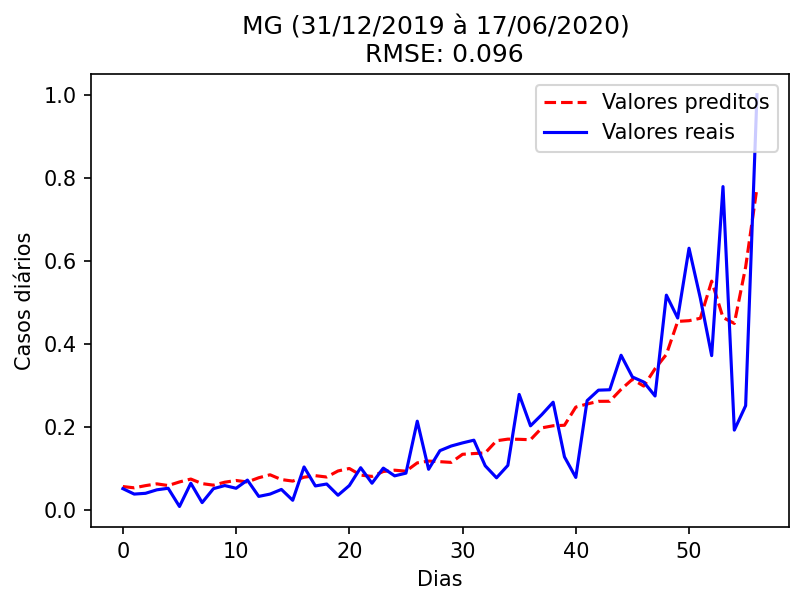

<Figure size 432x288 with 0 Axes>

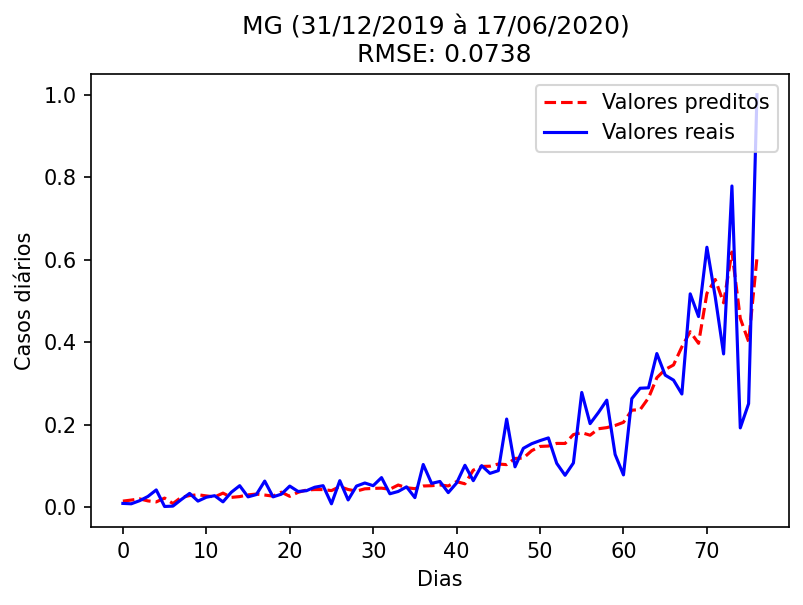

<Figure size 432x288 with 0 Axes>

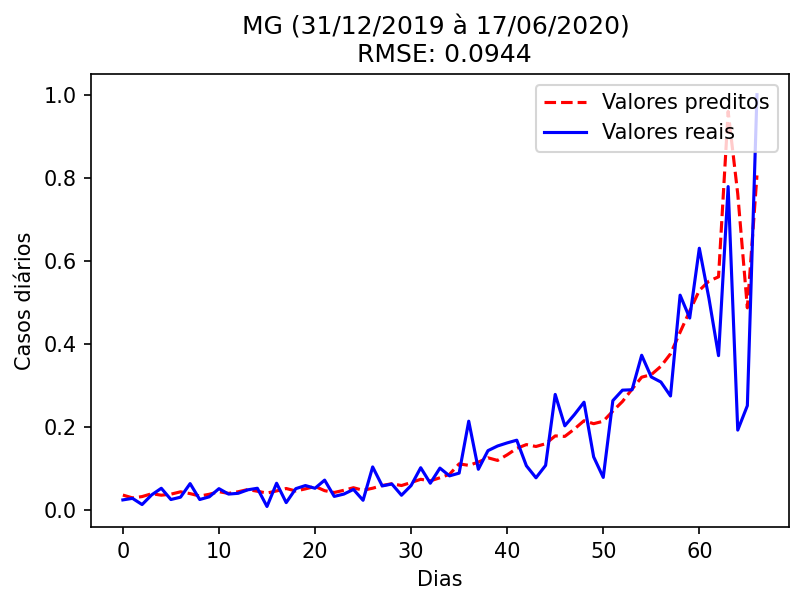

<Figure size 432x288 with 0 Axes>

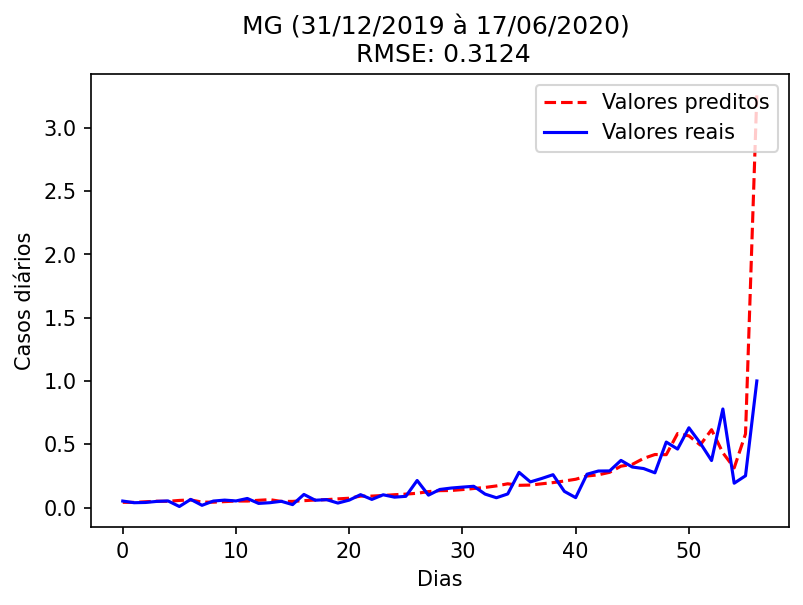

In [15]:
walk_epochs = [
   5, 10, 20, 50, 100
]

mg_paramsrange = multiplas_execucoes("MG", [(10, 7), (20, 7), (30, 7)], 
                                "MG (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", 
                                epochs_range = walk_epochs, is_walk = True)

In [18]:
mg_paramsrange.to_csv('/content/drive/My Drive/saida_mg.csv')

# Melhor modelo

Esta seção apresenta a execução do modelo que apresentou melhor desempenho aos dados. Abaixo, para iniciar, é feita a execução do modelo que teve o melhor desempenho.

Para a identificação do melhor modelo, faz-se a busca por aquele que apresenta o menor RMSE, como apresentado abaixo.

In [21]:
mg_paramsrange[mg_paramsrange['rmse'] == mg_paramsrange['rmse'].min()]

,nome_modelo,versao,entradas,rmse,epoch
0,Modelo_MG_v0,v0,"(10, 7)",0.072172,50


Com o modelo identificado, seu treinamento é feito novamente para que seja possível realizar sua aplicação para a previsão dos dados

In [23]:
gerarTreinamento_parametros("MG", "winner", 10, 7, epochs = 50)

Epoch 1/50
71/71 [==============================] - 2s 25ms/step - loss: 0.0192
Epoch 2/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0064
Epoch 3/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0061
Epoch 4/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0065
Epoch 5/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0066
Epoch 6/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0058
Epoch 7/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0057
Epoch 8/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0057
Epoch 9/50
71/71 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 10/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0068
Epoch 11/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 12/50
71/71 [==============================] - 1s 17ms/step - loss: 0.0053
Epoch 13/50
71/71 [==================

Com o modelo treinamento novamente, faz-se a validação de sua qualidade frente a predição dos dados

entrou condi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


<Figure size 432x288 with 0 Axes>

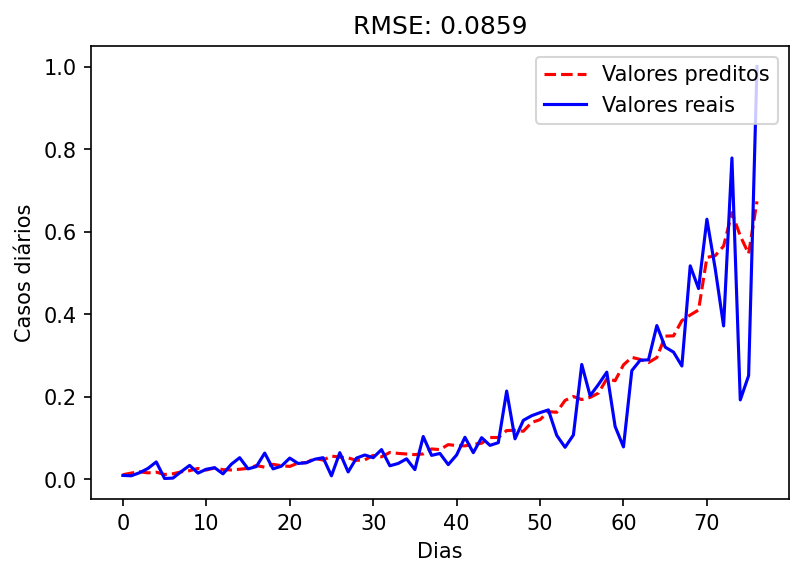

In [25]:
# pontos de entrada
n_entrada = 10
# pontos de saida
n_saida = 7
general_score = geraValidacao("MG", "Modelo_MG_winner", n_entrada, n_saida)

**Teste do modelo gerado**


Text(0.5, 1.0, 'Predição de casos diários de COVID-19 para os próximos 7 dias')

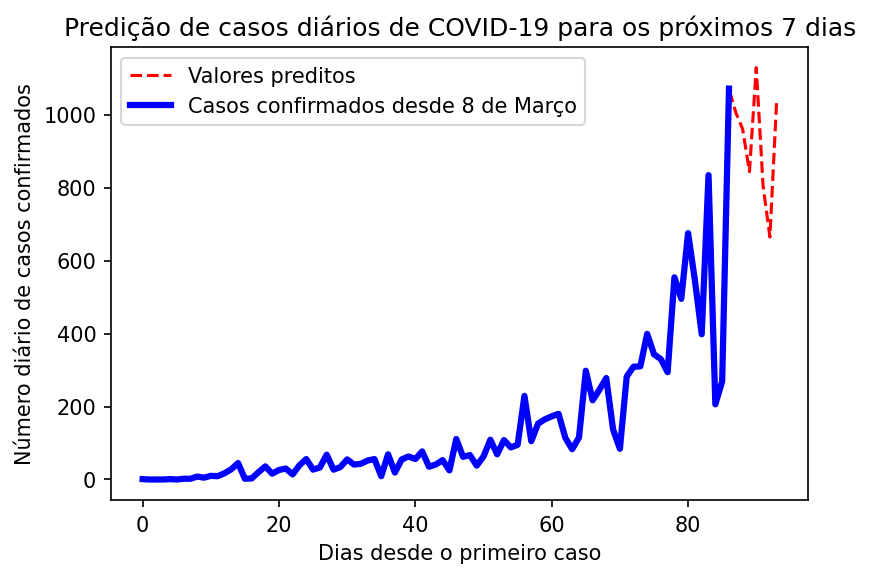

In [29]:
plt.figure(dpi = 150)
modelo = carregaModelo('Modelo_MG_winner')

daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", "MG")
dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)

input_array_2 =  np.array(dados_covid[-10:])

y_predict_val = predict(modelo,input_array_2, n_entrada)
predicted_serie = np.concatenate((dados_covid, y_predict_val))
predicted_serie_transform = scaler.inverse_transform(predicted_serie.reshape(len(predicted_serie),1))
dados_covid_transform = scaler.inverse_transform(dados_covid.reshape(len(dados_covid),1))

plt.plot(predicted_serie_transform, 'r--', label = 'Valores preditos')
plt.plot(dados_covid_transform, 'b', label = 'Casos confirmados desde 8 de Março', linewidth=3.0)

plt.xlabel('Dias desde o primeiro caso')
plt.ylabel('Número diário de casos confirmados')
plt.legend(loc ='upper left')
plt.title('Predição de casos diários de COVID-19 para os próximos 7 dias')